In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error

c:\Users\30586\AppData\Local\Programs\Python\Python36\lib\site-packages\google\auth\crypt\_cryptography_rsa.py:22: CryptographyDeprecationWarning: Python 3.6 is no longer supported by the Python core team. Therefore, support for it is deprecated in cryptography. The next release of cryptography will remove support for Python 3.6.
  import cryptography.exceptions


Importer des données

2023-06-24 01:59:10 - 2023-07-11 10:49:42
"09 July 2023:	Measurement error with regard to fine dust values due to sudden increase in air humidity"
Nous supprimons les données contenant des informations postérieures au 9 juillet

In [2]:

data=pd.read_csv("./one_room_apartement.csv")

In [3]:
data.head()

,TypPS,oxygen,pm10,cnt0_5,co,temperature,performance,co2,measuretime,so2,...,health,temperature_o2,cnt2_5,o3,humidity,dHdt,humidity_abs,sound,pm2_5,cnt0_3
0,1.995,20.863,6.004,273.935,1.726,23.718,805.0,490.458,1868,518.956,...,758.0,27.774,0.923,26.690,60.385,0.04,12.983,51.839,5.402,859.499
1,1.689,20.863,6.891,296.490,1.726,23.715,806.0,490.505,1867,520.396,...,715.0,27.762,0.739,26.594,60.377,0.03,12.980,52.092,6.451,932.282
2,2.854,20.863,7.486,268.740,1.726,23.716,808.0,489.080,1857,520.139,...,742.0,27.764,3.002,26.501,60.358,0.00,12.977,51.313,6.107,851.850
3,1.635,20.862,5.874,262.821,1.726,23.719,807.0,488.189,1881,518.782,...,746.0,27.748,1.287,26.611,60.426,0.03,12.993,53.420,5.489,829.355
4,1.579,20.864,7.068,297.597,1.725,23.712,809.0,485.401,1880,516.398,...,717.0,27.760,0.527,26.681,60.435,0.03,12.990,52.284,6.723,926.864


In [4]:
data.tail()

,TypPS,oxygen,pm10,cnt0_5,co,temperature,performance,co2,measuretime,so2,...,health,temperature_o2,cnt2_5,o3,humidity,dHdt,humidity_abs,sound,pm2_5,cnt0_3
12441,2.493,20.842,3.159,139.359,1.578,27.999,738.0,432.277,1799,715.633,...,661.0,32.491,0.652,30.628,47.086,0.00,12.860,59.537,2.733,432.119
12442,2.550,20.843,2.592,151.838,1.577,28.029,738.0,433.938,1782,723.661,...,653.0,32.507,0.590,30.105,47.237,0.08,12.923,59.008,2.277,475.226
12443,2.020,20.840,3.614,163.927,1.575,28.074,741.0,435.733,1804,733.135,...,650.0,32.559,1.847,29.544,47.292,0.31,12.970,59.580,3.254,520.100
12444,2.970,20.841,2.830,130.268,1.573,28.110,746.0,432.326,1799,739.224,...,654.0,32.575,1.636,29.012,47.268,0.36,12.989,59.275,2.154,408.629
12445,5.349,20.840,3.612,122.472,1.573,28.149,745.0,433.729,1786,747.578,...,648.0,32.597,3.106,28.614,47.254,0.23,13.013,59.092,1.747,381.507


Les données sont de 12445x31 et nous devons filtrer les valeurs nulles et les paramètres de mesure qui ne nous concernent pas.

In [5]:
print(data)

       TypPS  oxygen   pm10   cnt0_5     co  temperature  performance  \
0      1.995  20.863  6.004  273.935  1.726       23.718        805.0   
1      1.689  20.863  6.891  296.490  1.726       23.715        806.0   
2      2.854  20.863  7.486  268.740  1.726       23.716        808.0   
3      1.635  20.862  5.874  262.821  1.726       23.719        807.0   
4      1.579  20.864  7.068  297.597  1.725       23.712        809.0   
...      ...     ...    ...      ...    ...          ...          ...   
12441  2.493  20.842  3.159  139.359  1.578       27.999        738.0   
12442  2.550  20.843  2.592  151.838  1.577       28.029        738.0   
12443  2.020  20.840  3.614  163.927  1.575       28.074        741.0   
12444  2.970  20.841  2.830  130.268  1.573       28.110        746.0   
12445  5.349  20.840  3.612  122.472  1.573       28.149        745.0   

           co2  measuretime      so2  ...  health  temperature_o2 cnt2_5  \
0      490.458         1868  518.956  ...   758

In [6]:
nan_rows_count = data.isna().any(axis=1).sum()

print(f"\n Le nombre de lignes contenant des valeurs NaN est de: {nan_rows_count}")


 Le nombre de lignes contenant des valeurs NaN est de: 0


**Nettoyage des données**

Supprimer les lignes Nan et les colonnes de caractéristiques inintéressantes

In [7]:
data.drop(['TypPS', 'cnt0_5','cnt1','performance','measuretime','temperature_o2','sound_max','cnt5','cnt10','dCO2dt','health','cnt2_5','humidity_abs','dHdt','cnt0_3'], axis=1, inplace=True)
data.dropna(inplace=True)
data['timestamp'] = pd.to_datetime(data['timestamp'])

Nous supprimons les données contenant des informations postérieures au 9 juillet

"température", "pression", "humidité" à la fin des colonnes de données

In [8]:
dates_to_remove = ['2023-07-09','2023-07-10','2023-07-11']
dates_to_remove = pd.to_datetime(dates_to_remove)
data = data[~data['timestamp'].dt.normalize().isin(dates_to_remove)]
columns = list(data.columns)
columns.remove('temperature')
columns.remove('pressure')
columns.remove('humidity')
columns.extend(['temperature', 'pressure', 'humidity'])

data = data[columns]

Modifier le nom de timestamp et le convertir en index

In [9]:
data['timestamp'] = pd.to_datetime(data['timestamp'])

timestamp_col = data.pop('timestamp')
data.insert(0, 'date', timestamp_col)

data = data.set_index(['date'])

print(data.tail(10))

                     oxygen    pm10     co      co2      so2     no2     pm1  \
date                                                                           
2023-07-08 23:40:25  20.771  14.125  1.626  484.797  1139.90  69.921  10.375   
2023-07-08 23:42:24  20.771  13.626  1.625  485.178  1138.44  70.182  10.686   
2023-07-08 23:44:25  20.776  16.510  1.624  488.142  1136.82  70.427  11.233   
2023-07-08 23:46:25  20.778  17.540  1.621  486.802  1134.34  70.437  11.883   
2023-07-08 23:48:26  20.778  18.675  1.619  486.528  1132.36  70.288  12.278   
2023-07-08 23:50:26  20.778  15.895  1.616  485.832  1128.76  70.419  11.941   
2023-07-08 23:52:25  20.778  17.712  1.613  486.623  1123.33  70.439  12.091   
2023-07-08 23:54:26  20.778  15.942  1.611  487.518  1118.35  70.315  11.641   
2023-07-08 23:56:28  20.778  15.670  1.609  490.148  1115.68  69.342  11.238   
2023-07-08 23:58:27  20.776  18.649  1.607  493.541  1114.81  68.738  12.237   

                      dewpt     tvoc   

Présenter l'évolution de la valeur de la mesure qui nous intéresse au cours de l'échantillon

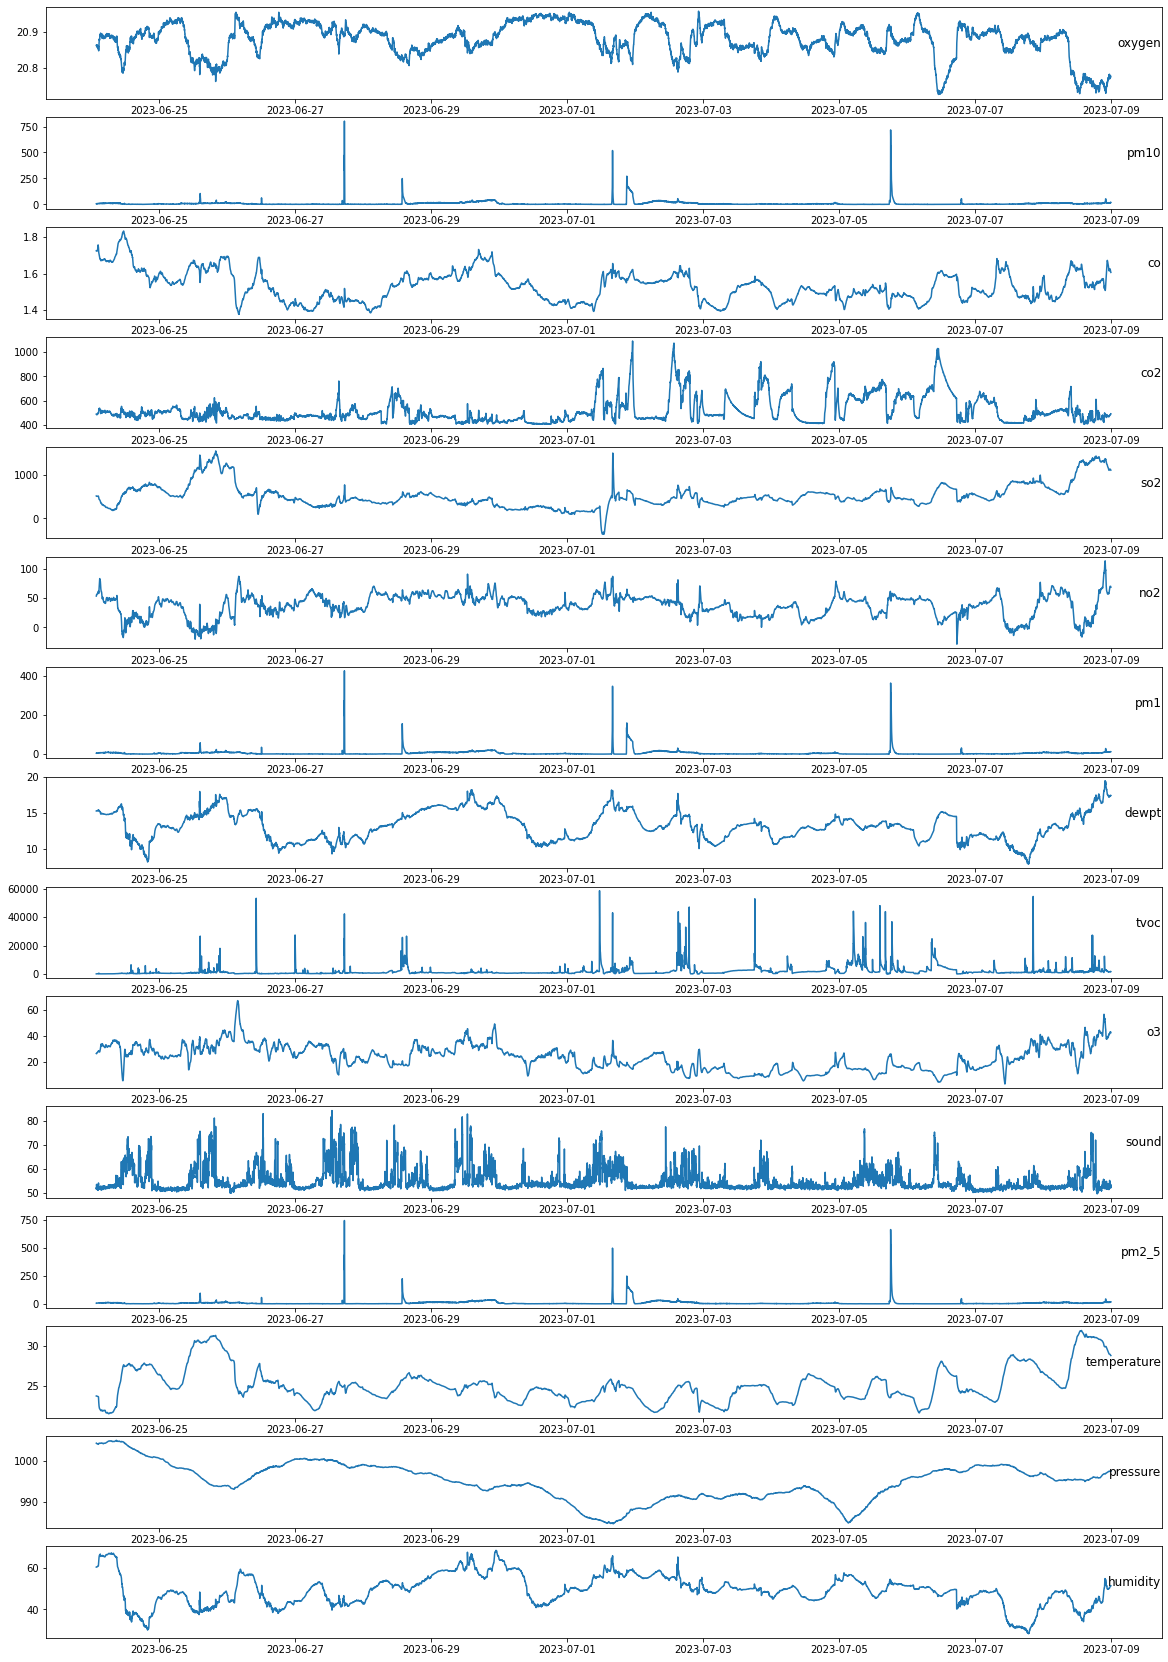

In [10]:
values = data.values
dates = data.index
groups = [0, 1, 2, 3, 4, 5, 6, 7 ,8 ,9 ,10 ,11 ,12, 13, 14]
i = 1

plt.figure(figsize=(20,30))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(dates,values[:, group])
    plt.title(data.columns[group], y=0.5, loc='right')
    i += 1
plt.show()#date

Voir la relation entre chaque paramètre et l'IQA

In [11]:
data['IAQ'] = (data['pm1']<=10) & (data['pm2_5']<=25) & (data['pm10']<=50) & (data['co2']<800) & (data['tvoc']<300) & (data['o3']<18)
data['IAQ'] = data['IAQ'].astype(object).replace({False: 0, True: 1})
data.insert(0, 'IAQ', data.pop('IAQ'))

In [12]:
d = data.corr()
display(d)

,IAQ,oxygen,pm10,co,co2,so2,no2,pm1,dewpt,tvoc,o3,sound,pm2_5,temperature,pressure,humidity
IAQ,1.000000,0.040541,-0.006796,-0.032924,-0.041035,-0.023573,-0.060246,-0.008092,-0.045370,-0.034978,-0.051391,-0.018295,-0.007208,-0.031929,-0.020781,-0.015658
oxygen,0.040541,1.000000,-0.083675,-0.538299,-0.379900,-0.682407,0.262147,-0.099734,-0.589558,-0.253354,0.028359,-0.205110,-0.084869,-0.737350,-0.073529,0.120042
pm10,-0.006796,-0.083675,1.000000,0.135594,0.015047,0.086961,0.145248,0.994451,0.207206,0.252317,0.103494,0.083859,0.999307,0.013013,-0.097140,0.174187
co,-0.032924,-0.538299,0.135594,1.000000,0.031835,0.354628,-0.143619,0.147324,0.606349,0.034506,0.220257,0.156498,0.136222,0.456679,0.213829,0.161436
co2,-0.041035,-0.379900,0.015047,0.031835,1.000000,0.012197,0.023755,0.010824,0.139560,0.419033,-0.509930,0.087385,0.015352,-0.065665,-0.203618,0.147290
so2,-0.023573,-0.682407,0.086961,0.354628,0.012197,1.000000,-0.389154,0.116932,0.274829,0.109988,0.275572,0.061561,0.091468,0.878911,0.197875,-0.498152
no2,-0.060246,0.262147,0.145248,-0.143619,0.023755,-0.389154,1.000000,0.140755,0.312170,0.001334,0.314445,-0.104622,0.140876,-0.514044,-0.101777,0.683111
pm1,-0.008092,-0.099734,0.994451,0.147324,0.010824,0.116932,0.140755,1.000000,0.221787,0.258132,0.121678,0.078829,0.995906,0.038859,-0.086776,0.165491
dewpt,-0.045370,-0.589558,0.207206,0.606349,0.139560,0.274829,0.312170,0.221787,1.000000,0.132168,0.259312,0.114135,0.206121,0.292945,-0.187010,0.602923
tvoc,-0.034978,-0.253354,0.252317,0.034506,0.419033,0.109988,0.001334,0.258132,0.132168,1.000000,-0.249763,0.106284,0.253929,0.057067,-0.213156,0.053747


Une carte thermique（est un moyen de montrer la corrélation entre plusieurs variables à la fois.）

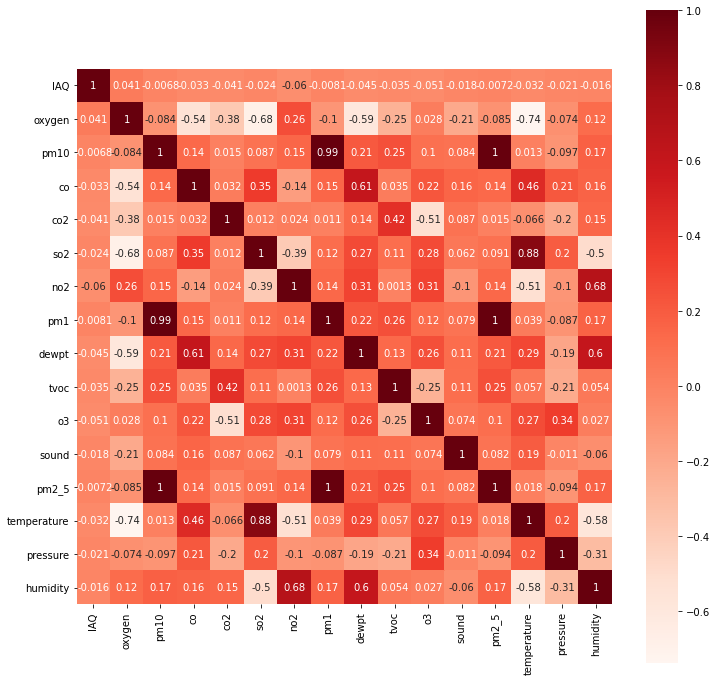

In [13]:
import seaborn as sns
plt.subplots(figsize = (12,12))
sns.heatmap(d,annot = True,vmax = 1,square = True,cmap = "Reds")
plt.show()

Supprimer les IAQ pour éviter que diverses opérations n'affectent les données par la suite.

In [14]:
data.drop('IAQ', axis=1, inplace=True)
data

,oxygen,pm10,co,co2,so2,no2,pm1,dewpt,tvoc,o3,sound,pm2_5,temperature,pressure,humidity
date,,,,,,,,,,,,,,,
2023-06-24 01:59:10,20.863,6.004,1.726,490.458,518.956,53.683,4.772,15.243,88.673,26.690,51.839,5.402,23.718,1004.360,60.385
2023-06-24 02:01:10,20.863,6.891,1.726,490.505,520.396,54.946,5.906,15.239,87.726,26.594,52.092,6.451,23.715,1004.340,60.377
2023-06-24 02:03:11,20.863,7.486,1.726,489.080,520.139,55.795,5.004,15.235,98.224,26.501,51.313,6.107,23.716,1004.320,60.358
2023-06-24 02:05:11,20.862,5.874,1.726,488.189,518.782,56.146,4.991,15.255,91.344,26.611,53.420,5.489,23.719,1004.300,60.426
2023-06-24 02:07:11,20.864,7.068,1.725,485.401,516.398,56.341,5.839,15.251,85.264,26.681,52.284,6.723,23.712,1004.280,60.435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-08 23:50:26,20.778,15.895,1.616,485.832,1128.760,70.419,11.941,17.363,1522.430,43.174,52.033,14.813,28.801,997.579,51.186
2023-07-08 23:52:25,20.778,17.712,1.613,486.623,1123.330,70.439,12.091,17.372,1393.730,43.357,51.868,17.004,28.790,997.549,51.247
2023-07-08 23:54:26,20.778,15.942,1.611,487.518,1118.350,70.315,11.641,17.380,1451.100,43.350,52.146,15.244,28.779,997.534,51.304


**Multivariate LSTM Predictive Modeling**

In [15]:
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from keras.regularizers import l1, l2
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


Les données de la série temporelle sont converties en données d'apprentissage supervisé et des étiquettes sont générées. Les variables d'entrée sont ensuite normalisées. Compte tenu des mesures de la pollution et des conditions météorologiques de l'heure précédente (t-1), nous posons le problème de l'apprentissage supervisé pour prédire la concentration de la pollution à l'heure actuelle (t).

In [16]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    #  (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)] 
    agg = pd.concat(cols, axis=1)
    agg.columns = names


    if dropnan:
        agg.dropna(inplace=True)

    return agg

In [17]:
values = data.values

values = values.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

reframed = series_to_supervised(scaled, 1, 1)
reframed.drop(reframed.columns[[-1,-2,-3]], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),...,var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var9(t),var10(t),var11(t),var12(t)
1,0.588753,0.007486,0.763676,0.121727,0.459352,0.577556,0.011164,0.637324,0.001507,0.365211,...,0.763676,0.121795,0.460102,0.586407,0.013817,0.636977,0.001491,0.363713,0.076055,0.008636
2,0.588753,0.008592,0.763676,0.121795,0.460102,0.586407,0.013817,0.636977,0.001491,0.363713,...,0.763676,0.119705,0.459968,0.592357,0.011707,0.636631,0.001670,0.362262,0.053790,0.008175
3,0.588753,0.009334,0.763676,0.119705,0.459968,0.592357,0.011707,0.636631,0.001670,0.362262,...,0.763676,0.118399,0.459262,0.594817,0.011677,0.638362,0.001553,0.363978,0.114010,0.007348
4,0.584419,0.007324,0.763676,0.118399,0.459262,0.594817,0.011677,0.638362,0.001553,0.363978,...,0.761488,0.114310,0.458021,0.596183,0.013661,0.638016,0.001449,0.365070,0.081542,0.009000
5,0.593079,0.008813,0.761488,0.114310,0.458021,0.596183,0.013661,0.638016,0.001449,0.365070,...,0.759300,0.112774,0.457025,0.597494,0.011978,0.637930,0.001466,0.367301,0.067623,0.007897


80% train - 20% test
Ligne de départ de l'ensemble de données de test = train_x.shape[0]+1(onglet)+x(projetée)+1(test)
（2023-06-24 02:01:10<3> - 2023-07-06 00:18:22<8559>）         （2023-07-06 00:20:20<8560> - 2023-07-08 23:58:27<10698>）

In [18]:
values = reframed.values
num_rows = data.shape[0]
train_samples = int(num_rows // 1.25)
train = reframed.iloc[:train_samples, :]
test = reframed.iloc[train_samples:, :]

train_X, train_y = train.iloc[:, :-12].values, train.iloc[:, -12:].values
test_X, test_y = test.iloc[:, :-12].values, test.iloc[:, -12:].values

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8557, 1, 15) (8557, 12) (2139, 1, 15) (2139, 12)


Define the LSTM model

Il y a 50 neurones dans la première couche cachée et 11 neurones dans la couche de sortie pour prédire la concentration de pollution. La dimension des données d'entrée sera de 1 pas de temps (c'est-à-dire 2 secondes) et de 14 caractéristiques.

In [19]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.3))
model.add(Dense(12))
model.compile(loss='mae', optimizer='adam')
print(model.summary())
# model = Sequential()
# model.add(LSTM(40, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(50))
# model.add(Dropout(0.2))
# model.add(Dense(11))
# model.compile(optimizer='adam', loss='mae')
# model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                13200     
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 12)                612       
Total params: 13,812
Trainable params: 13,812
Non-trainable params: 0
_________________________________________________________________
None


Training the LSTM model

Epoch 1/400


119/119 - 1s - loss: 0.1420 - val_loss: 0.0989
Epoch 2/400
119/119 - 0s - loss: 0.0925 - val_loss: 0.0873
Epoch 3/400
119/119 - 0s - loss: 0.0805 - val_loss: 0.0766
Epoch 4/400
119/119 - 0s - loss: 0.0696 - val_loss: 0.0655
Epoch 5/400
119/119 - 0s - loss: 0.0603 - val_loss: 0.0585
Epoch 6/400
119/119 - 0s - loss: 0.0549 - val_loss: 0.0544
Epoch 7/400
119/119 - 0s - loss: 0.0508 - val_loss: 0.0519
Epoch 8/400
119/119 - 0s - loss: 0.0482 - val_loss: 0.0501
Epoch 9/400
119/119 - 0s - loss: 0.0458 - val_loss: 0.0479
Epoch 10/400
119/119 - 0s - loss: 0.0443 - val_loss: 0.0467
Epoch 11/400
119/119 - 0s - loss: 0.0427 - val_loss: 0.0452
Epoch 12/400
119/119 - 0s - loss: 0.0410 - val_loss: 0.0435
Epoch 13/400
119/119 - 0s - loss: 0.0402 - val_loss: 0.0423
Epoch 14/400
119/119 - 0s - loss: 0.0384 - val_loss: 0.0405
Epoch 15/400
119/119 - 0s - loss: 0.0377 - val_loss: 0.0393
Epoch 16/400
119/119 - 0s - loss: 0.0372 - val_loss: 0.0368
Epoch 17/400
119/119 - 0s - loss: 0.0361 - val_loss: 0.0366
E

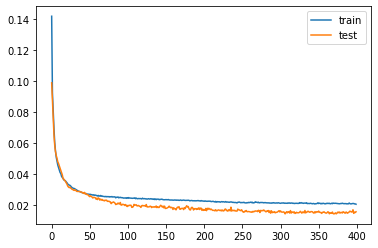

In [20]:
history = model.fit(train_X, train_y, epochs=400, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# history = model.fit(train_X, train_y, epochs=150, batch_size=32, validation_data=(test_X, test_y), verbose=2, shuffle=False)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Evaluating LSTM models

Les prédictions de sortie sont obtenues grâce au modèle, puis les valeurs réelles sont obtenues à partir des données d'origine.

In [21]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
selected_columns = [i for i in range(test_X.shape[1]) if i in [12, 13, 14]]
# selected_columns2 = [i for i in range(test_X.shape[1]) if i not in [3, 10, 11]]
inv_yhat = np.concatenate((yhat, test_X[:, selected_columns]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,:-3]
# oxygen_predict = inv_yhat[:, 0]
# pm10_predict = inv_yhat[:, 1]
# co_predict = inv_yhat[:, 2]
# co2_predict = inv_yhat[:, 3]
# so2_predict = inv_yhat[:, 4]
# no2_predict = inv_yhat[:, 5]
# pm1_predict = inv_yhat[:, 6]
# dewpt_predict = inv_yhat[:, 7]
# tvoc_predict = inv_yhat[:, 8]
# pm2_5_predict = inv_yhat[:, 9]

test_y = test_y.reshape((len(test_y), train_y.shape[1]))
inv_y = np.concatenate((test_y, test_X[:, selected_columns]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,:-3]
inv_y_df = pd.DataFrame(inv_y)
print(inv_y_df.head())
# oxygen_reel = inv_y[:, 0]
# pm10_reel = inv_y[:, 1]
# co_reel = inv_y[:, 2]
# co2_reel = inv_y[:, 3]
# so2_reel = inv_y[:, 4]
# no2_reel = inv_y[:, 5]
# pm1_reel = inv_y[:, 6]
# dewpt_reel = inv_y[:, 7]
# tvoc_reel = inv_y[:, 8]
# pm2_5_reel = inv_y[:, 9]

# rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
# print('Test RMSE: %.3f' % rmse)


          0      1      2           3           4          5      6   \
0  20.881001  1.002  1.479  661.971008  438.337982  47.824005  0.326   
1  20.881001  0.485  1.479  651.153992  437.725983  47.506008  0.069   
2  20.879999  0.378  1.478  653.598999  435.914001  47.601002  0.252   
3  20.879999  0.836  1.478  665.013977  435.846954  47.555004  0.438   
4  20.879000  0.734  1.478  668.629028  436.254974  47.664001  0.465   

          7            8       9          10     11  
0  12.763999  1159.930054  15.432  52.966000  0.699  
1  12.744000  1146.650024  15.361  52.457001  0.118  
2  12.749000  1146.369995  15.342  52.323002  0.336  
3  12.745001  1163.060059  15.323  51.528999  0.527  
4  12.740999  1190.010010  15.343  51.537998  0.502  


Afficher valeur pic sur tvoc

Comme je veux trouver la relation entre les paramètres, je vais choisir des valeurs de pic pour découvrir la relation entre les paramètres. Mais cela semble lourd et difficile à observer, nous utilisons la méthode de la carte thermique pour y parvenir.

In [22]:
col_index = 8
col_values = inv_y_df.iloc[:, col_index]

filtered_rows = col_values[col_values > 8000]
date_indices = filtered_rows.index + train_X.shape[0] + 1
datepic = data.iloc[date_indices, col_index]
for index, value in filtered_rows.items():
    print(f"nb de ligne: {index}, valeur: {value}, dates: {datepic}\n")

nb de ligne: 247, valeur: 12475.2998046875, dates: date
2023-07-06 08:39:58    12475.30
2023-07-06 08:41:59    22527.60
2023-07-06 08:44:01    19906.70
2023-07-06 08:46:02    16101.50
2023-07-06 08:48:03    14818.90
                         ...   
2023-07-08 18:17:36    12805.50
2023-07-08 18:19:36     8968.61
2023-07-08 19:47:53     9784.25
2023-07-08 21:42:09    12539.60
2023-07-08 21:44:09     9607.30
Name: tvoc, Length: 95, dtype: float64

nb de ligne: 248, valeur: 22527.599609375, dates: date
2023-07-06 08:39:58    12475.30
2023-07-06 08:41:59    22527.60
2023-07-06 08:44:01    19906.70
2023-07-06 08:46:02    16101.50
2023-07-06 08:48:03    14818.90
                         ...   
2023-07-08 18:17:36    12805.50
2023-07-08 18:19:36     8968.61
2023-07-08 19:47:53     9784.25
2023-07-08 21:42:09    12539.60
2023-07-08 21:44:09     9607.30
Name: tvoc, Length: 95, dtype: float64

nb de ligne: 249, valeur: 19906.69921875, dates: date
2023-07-06 08:39:58    12475.30
2023-07-06 08:41:59

Comparaison des valeurs prédites et des valeurs réelles pour 12 valeurs de sortie

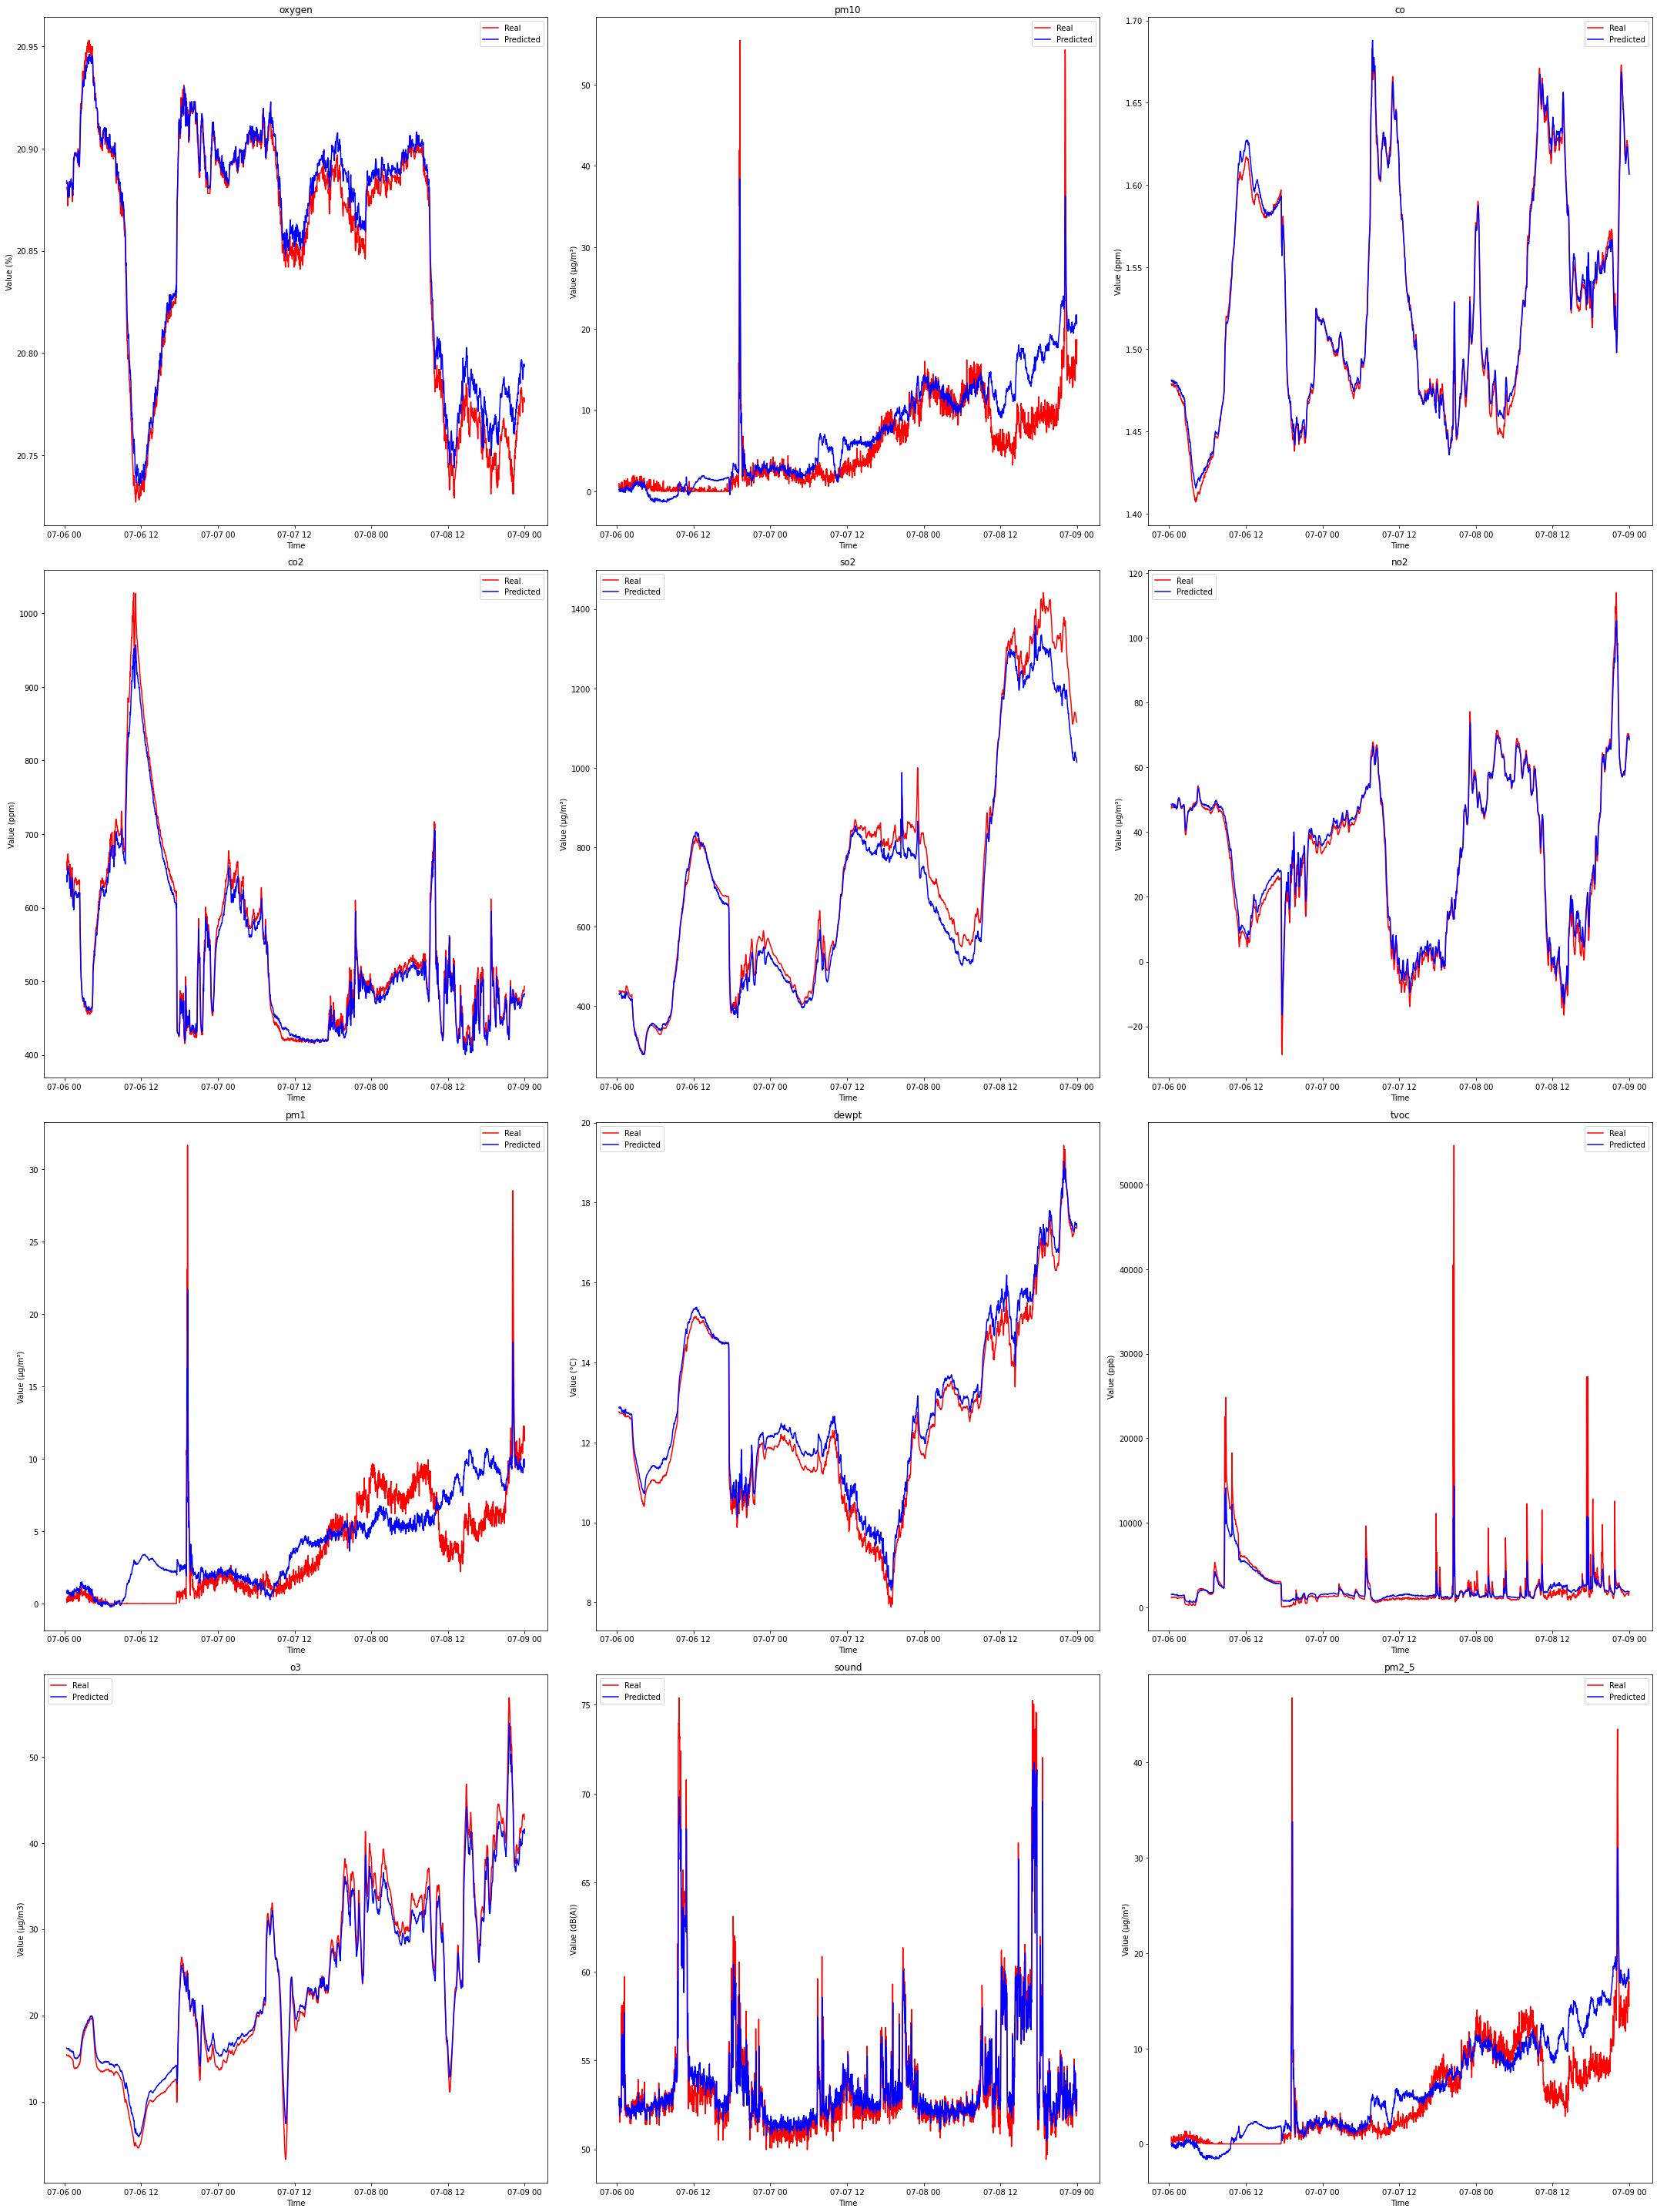

In [23]:
dates = dates[-test_y.shape[0]:]
fig, axs = plt.subplots(4, 3, figsize=(30, 40))
feature_indices = {
    'oxygen': 0, 'pm10': 1, 'co': 2, 'co2': 3, 'so2': 4,
    'no2': 5, 'pm1': 6, 'dewpt': 7, 'tvoc': 8, 'o3' : 9, 'sound': 10, 'pm2_5': 11
}

feature_units = {
    'oxygen': '%', 'pm10': 'µg/m³', 'co': 'ppm', 'co2': 'ppm',
    'so2': 'µg/m³', 'no2': 'µg/m³', 'pm1': 'µg/m³',
    'dewpt': '°C', 'tvoc': 'ppb', 'o3': 'µg/m3', 'sound': 'dB(A)', 'pm2_5': 'µg/m³'
}

for i, (feature, index) in enumerate(feature_indices.items()):
    row = i // 3
    col = i % 3

    axs[row, col].plot(dates,inv_y[:, index], color='red', label='Real')
    axs[row, col].plot(dates,inv_yhat[:, index], color='blue', label='Predicted')
    axs[row, col].set_title(feature)
    axs[row, col].set_xlabel('Time')
    axs[row, col].set_ylabel(f'Value ({feature_units[feature]})')
    axs[row, col].legend()

plt.tight_layout()
plt.show()

Calcul de l'RMSE(Root Mean Square Error)

In [24]:

print(inv_y.shape, inv_yhat.shape)
selected_columns2 = [i for i in range(test_X.shape[1]) if i not in [12, 13, 14]]
inv_yhat = inv_yhat[:, selected_columns2]
inv_y = inv_y[:, selected_columns2]
feature_names = ['oxygen', 'pm10', 'co', 'co2', 'so2', 'no2', 'pm1', 'dewpt', 'tvoc', 'o3' ,'sound', 'pm2_5']

for i, feature in enumerate(feature_names):
    rmse = sqrt(mean_squared_error(inv_y[:, i], inv_yhat[:, i]))
    # # Avoid division by zero for MAPE
    # actual_values = inv_y[:, i]
    # predicted_values = inv_yhat[:, i]
    # # Replace zeros in actual values with a small number (1e-10)
    # actual_values = np.where(actual_values == 0, 1e-10, actual_values)
    # mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100
    print(f'Test RMSE for {feature}: {rmse:.3f}')
    # print(f'Rest MAPE for {feature}: {mape:.3f}%')

(2139, 12) (2139, 12)
Test RMSE for oxygen: 0.010
Test RMSE for pm10: 3.600
Test RMSE for co: 0.005
Test RMSE for co2: 16.721
Test RMSE for so2: 48.434
Test RMSE for no2: 2.538
Test RMSE for pm1: 2.250
Test RMSE for dewpt: 0.369
Test RMSE for tvoc: 2069.587
Test RMSE for o3: 1.413
Test RMSE for sound: 1.449
Test RMSE for pm2_5: 3.000


In [25]:
iaqi_condition_withouto3 = lambda x: (x[:, 6] <= 10) & (x[:, 11] <= 25) & (x[:, 1] <= 50) & (x[:, 3] < 800) & (x[:, 8] < 300)
iaqi_condition = lambda x: (x[:, 6] <= 10) & (x[:, 10] <= 25) & (x[:, 1] <= 50) & (x[:, 3] < 800) & (x[:, 8] < 300) & (x[:, 9] < 18)
inv_y_iaq = iaqi_condition_withouto3(inv_y).astype(int)
inv_yhat_iaq = iaqi_condition_withouto3(inv_yhat).astype(int)
inv_y_iaq2 = iaqi_condition(inv_y).astype(int)
inv_yhat_iaq2 = iaqi_condition(inv_yhat).astype(int)

inv_y = np.hstack((inv_y, inv_y_iaq.reshape(-1, 1)))
inv_yhat = np.hstack((inv_yhat, inv_yhat_iaq.reshape(-1, 1)))
inv_y2 = np.hstack((inv_y, inv_y_iaq2.reshape(-1, 1)))
inv_yhat2 = np.hstack((inv_yhat, inv_yhat_iaq2.reshape(-1, 1)))

In [26]:
# print("inv_y:\n", inv_y)
# print("inv_yhat:\n", inv_yhat)

In [27]:

from sklearn.metrics import accuracy_score
accuracy_normalized = accuracy_score(inv_y[:,12], inv_yhat[:,12], normalize=True)
print("Accuracy: " + str(accuracy_normalized))

Accuracy: 0.9621318373071529


In [28]:
accuracy_normalized = accuracy_score(inv_y2[:,12], inv_yhat2[:,12], normalize=True)
print("Accuracy: " + str(accuracy_normalized))

Accuracy: 0.9621318373071529


In [29]:
num_correct = accuracy_score(inv_y[:,12], inv_yhat[:,12], normalize=False)
print(num_correct) 


2058


anticiper

In [30]:
# 7*2 = 14 min
n_temps = 7
n_features = 15

reframed = series_to_supervised(scaled, n_temps, 1)

In [31]:
reframed.drop(reframed.columns[[-1,-2,-3]], axis=1, inplace=True)
reframed.head(10)

,var1(t-7),var2(t-7),var3(t-7),var4(t-7),var5(t-7),var6(t-7),var7(t-7),var8(t-7),var9(t-7),var10(t-7),...,var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var9(t),var10(t),var11(t),var12(t)
7,0.588753,0.007486,0.763676,0.121727,0.459352,0.577556,0.011164,0.637324,0.001507,0.365211,...,0.757112,0.115279,0.454809,0.596099,0.012343,0.638189,0.001476,0.370624,0.079570,0.008455
8,0.588753,0.008592,0.763676,0.121795,0.460102,0.586407,0.013817,0.636977,0.001491,0.363713,...,0.759300,0.115752,0.454247,0.596541,0.014250,0.639488,0.001593,0.373339,0.056076,0.009624
9,0.588753,0.009334,0.763676,0.119705,0.459968,0.592357,0.011707,0.636631,0.001670,0.362262,...,0.761488,0.119245,0.454146,0.598910,0.012694,0.640353,0.001630,0.373994,0.078770,0.008112
10,0.584419,0.007324,0.763676,0.118399,0.459262,0.594817,0.011677,0.638362,0.001553,0.363978,...,0.761488,0.119999,0.454584,0.599891,0.013036,0.639314,0.002238,0.374384,0.068967,0.009314
11,0.593079,0.008813,0.761488,0.114310,0.458021,0.596183,0.013661,0.638016,0.001449,0.365070,...,0.768053,0.121418,0.455741,0.601804,0.012603,0.640180,0.003386,0.376053,0.074111,0.008089
12,0.593079,0.008857,0.759300,0.112774,0.457025,0.597494,0.011978,0.637930,0.001466,0.367301,...,0.772429,0.125503,0.456684,0.604957,0.012919,0.640613,0.003392,0.379095,0.056819,0.009522
13,0.593079,0.008218,0.759300,0.112717,0.455760,0.596975,0.012386,0.638016,0.001472,0.369095,...,0.776805,0.123783,0.457308,0.607487,0.012776,0.640959,0.003172,0.381638,0.062364,0.008471
14,0.588753,0.008789,0.757112,0.115279,0.454809,0.596099,0.012343,0.638189,0.001476,0.370624,...,0.781182,0.132610,0.457578,0.611405,0.015163,0.643988,0.002926,0.383354,0.045587,0.009887
15,0.593079,0.009619,0.759300,0.115752,0.454247,0.596541,0.014250,0.639488,0.001593,0.373339,...,0.783370,0.134140,0.457142,0.614481,0.014709,0.644854,0.002631,0.385710,0.059049,0.009942
16,0.593079,0.008591,0.761488,0.119245,0.454146,0.598910,0.012694,0.640353,0.001630,0.373994,...,0.792123,0.131066,0.457181,0.616324,0.015106,0.644421,0.002414,0.387675,0.071653,0.010300


In [32]:
values = reframed.values
num_rows = data.shape[0]
train_samples = int(num_rows // 1.25)

train = values[:train_samples, :]
test = values[train_samples:, :]
n_obs = n_temps * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features+3:]
test_X, test_y = test[:, :n_obs], test[:, -n_features+3:]
print( train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8557, 105) (8557, 12) (2133, 105) (2133, 12)


In [33]:
train_X = train_X.reshape((train_X.shape[0], n_temps, n_features))
test_X = test_X.reshape((test_X.shape[0], n_temps, n_features))

print(test_X.shape,train_X.shape)

(2133, 7, 15) (8557, 7, 15)


In [34]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.3))
model.add(Dense(12))
model.compile(loss='mae', optimizer='adam')
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                13200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 12)                612       
Total params: 13,812
Trainable params: 13,812
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/400
119/119 - 1s - loss: 0.1444 - val_loss: 0.0940
Epoch 2/400
119/119 - 0s - loss: 0.0879 - val_loss: 0.0697
Epoch 3/400
119/119 - 0s - loss: 0.0697 - val_loss: 0.0611
Epoch 4/400
119/119 - 0s - loss: 0.0604 - val_loss: 0.0579
Epoch 5/400
119/119 - 0s - loss: 0.0539 - val_loss: 0.0512
Epoch 6/400
119/119 - 0s - loss: 0.0493 - val_loss: 0.0475
Epoch 7/400
119/119 - 0s - loss: 0.0458 - val_loss: 0.0438
Epoch 8/400
119/119 - 0s - loss: 0.0432 - val_loss: 0.0406
Epoch 9/400
119/119 - 0s - loss: 0.0417 - val_loss: 0.0389
Epoch 10/400
119/119 - 0s - loss: 0.0402 - val_loss: 0.0388
Epoch 11/400
119/119 - 0s - loss: 0.0391 - val_loss: 0.0361
Epoch 12/400
119/119 - 0s - loss: 0.0376 - val_loss: 0.0364
Epoch 13/400
119/119 - 0s - loss: 0.0364 - val_loss: 0.0344
Epoch 14/400
119/119 - 0s - loss: 0.0359 - val_loss: 0.0338
Epoch 15/400
119/119 - 0s - loss: 0.0350 - val_loss: 0.0325
Epoch 16/400
119/119 - 0s - loss: 0.0343 - val_loss: 0.0328
Epoch 17/400
119/119 - 0s - loss: 0.0342 - val_lo

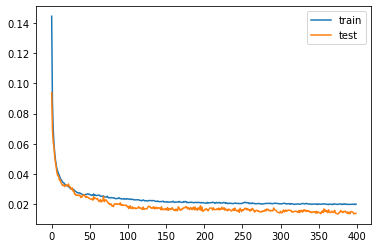

In [35]:
history = model.fit(train_X, train_y, epochs=400, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [37]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_temps*n_features))

selected_columns = [i for i in range(test_X.shape[1]) if i in [12, 13, 14]]

inv_yhat = np.concatenate((yhat, test_X[:, selected_columns]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
# inv_yhat = inv_yhat[:, selected_columns2]

test_y = test_y.reshape(len(test_y), test_y.shape[1])
inv_y = np.concatenate((test_y, test_X[:, selected_columns]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,:-3]
inv_y_df = pd.DataFrame(inv_y)
print(inv_y_df.head())

          0      1      2           3           4          5      6       7   \
0  20.875999  0.494  1.478  673.091980  438.166992  47.861004  0.314  12.733   
1  20.877001  0.174  1.479  669.117004  437.809021  47.721004  0.128  12.730   
2  20.877001  0.389  1.478  663.067993  437.946014  47.740005  0.289  12.728   
3  20.879000  0.780  1.478  661.744019  438.044983  47.889004  0.502  12.729   
4  20.878000  0.492  1.478  663.919983  436.010010  47.858002  0.136  12.725   

            8       9          10     11  
0  1169.959961  15.370  52.881001  0.491  
1  1145.729980  15.375  52.095001  0.174  
2  1137.619995  15.366  52.841000  0.389  
3  1132.069946  15.388  52.228001  0.558  
4  1165.359985  15.355  52.105000  0.172  


In [38]:
col_index = 8
col_values = inv_y_df.iloc[:, col_index]

date_indices = filtered_rows.index + train_X.shape[0] + 1
datepic = data.iloc[date_indices, col_index]
for index, value in filtered_rows.items():
    print(f"nb de ligne: {index}, valeur: {value}, dates: {datepic}\n")

nb de ligne: 247, valeur: 12475.2998046875, dates: date
2023-07-06 08:39:58    12475.30
2023-07-06 08:41:59    22527.60
2023-07-06 08:44:01    19906.70
2023-07-06 08:46:02    16101.50
2023-07-06 08:48:03    14818.90
                         ...   
2023-07-08 18:17:36    12805.50
2023-07-08 18:19:36     8968.61
2023-07-08 19:47:53     9784.25
2023-07-08 21:42:09    12539.60
2023-07-08 21:44:09     9607.30
Name: tvoc, Length: 95, dtype: float64

nb de ligne: 248, valeur: 22527.599609375, dates: date
2023-07-06 08:39:58    12475.30
2023-07-06 08:41:59    22527.60
2023-07-06 08:44:01    19906.70
2023-07-06 08:46:02    16101.50
2023-07-06 08:48:03    14818.90
                         ...   
2023-07-08 18:17:36    12805.50
2023-07-08 18:19:36     8968.61
2023-07-08 19:47:53     9784.25
2023-07-08 21:42:09    12539.60
2023-07-08 21:44:09     9607.30
Name: tvoc, Length: 95, dtype: float64

nb de ligne: 249, valeur: 19906.69921875, dates: date
2023-07-06 08:39:58    12475.30
2023-07-06 08:41:59

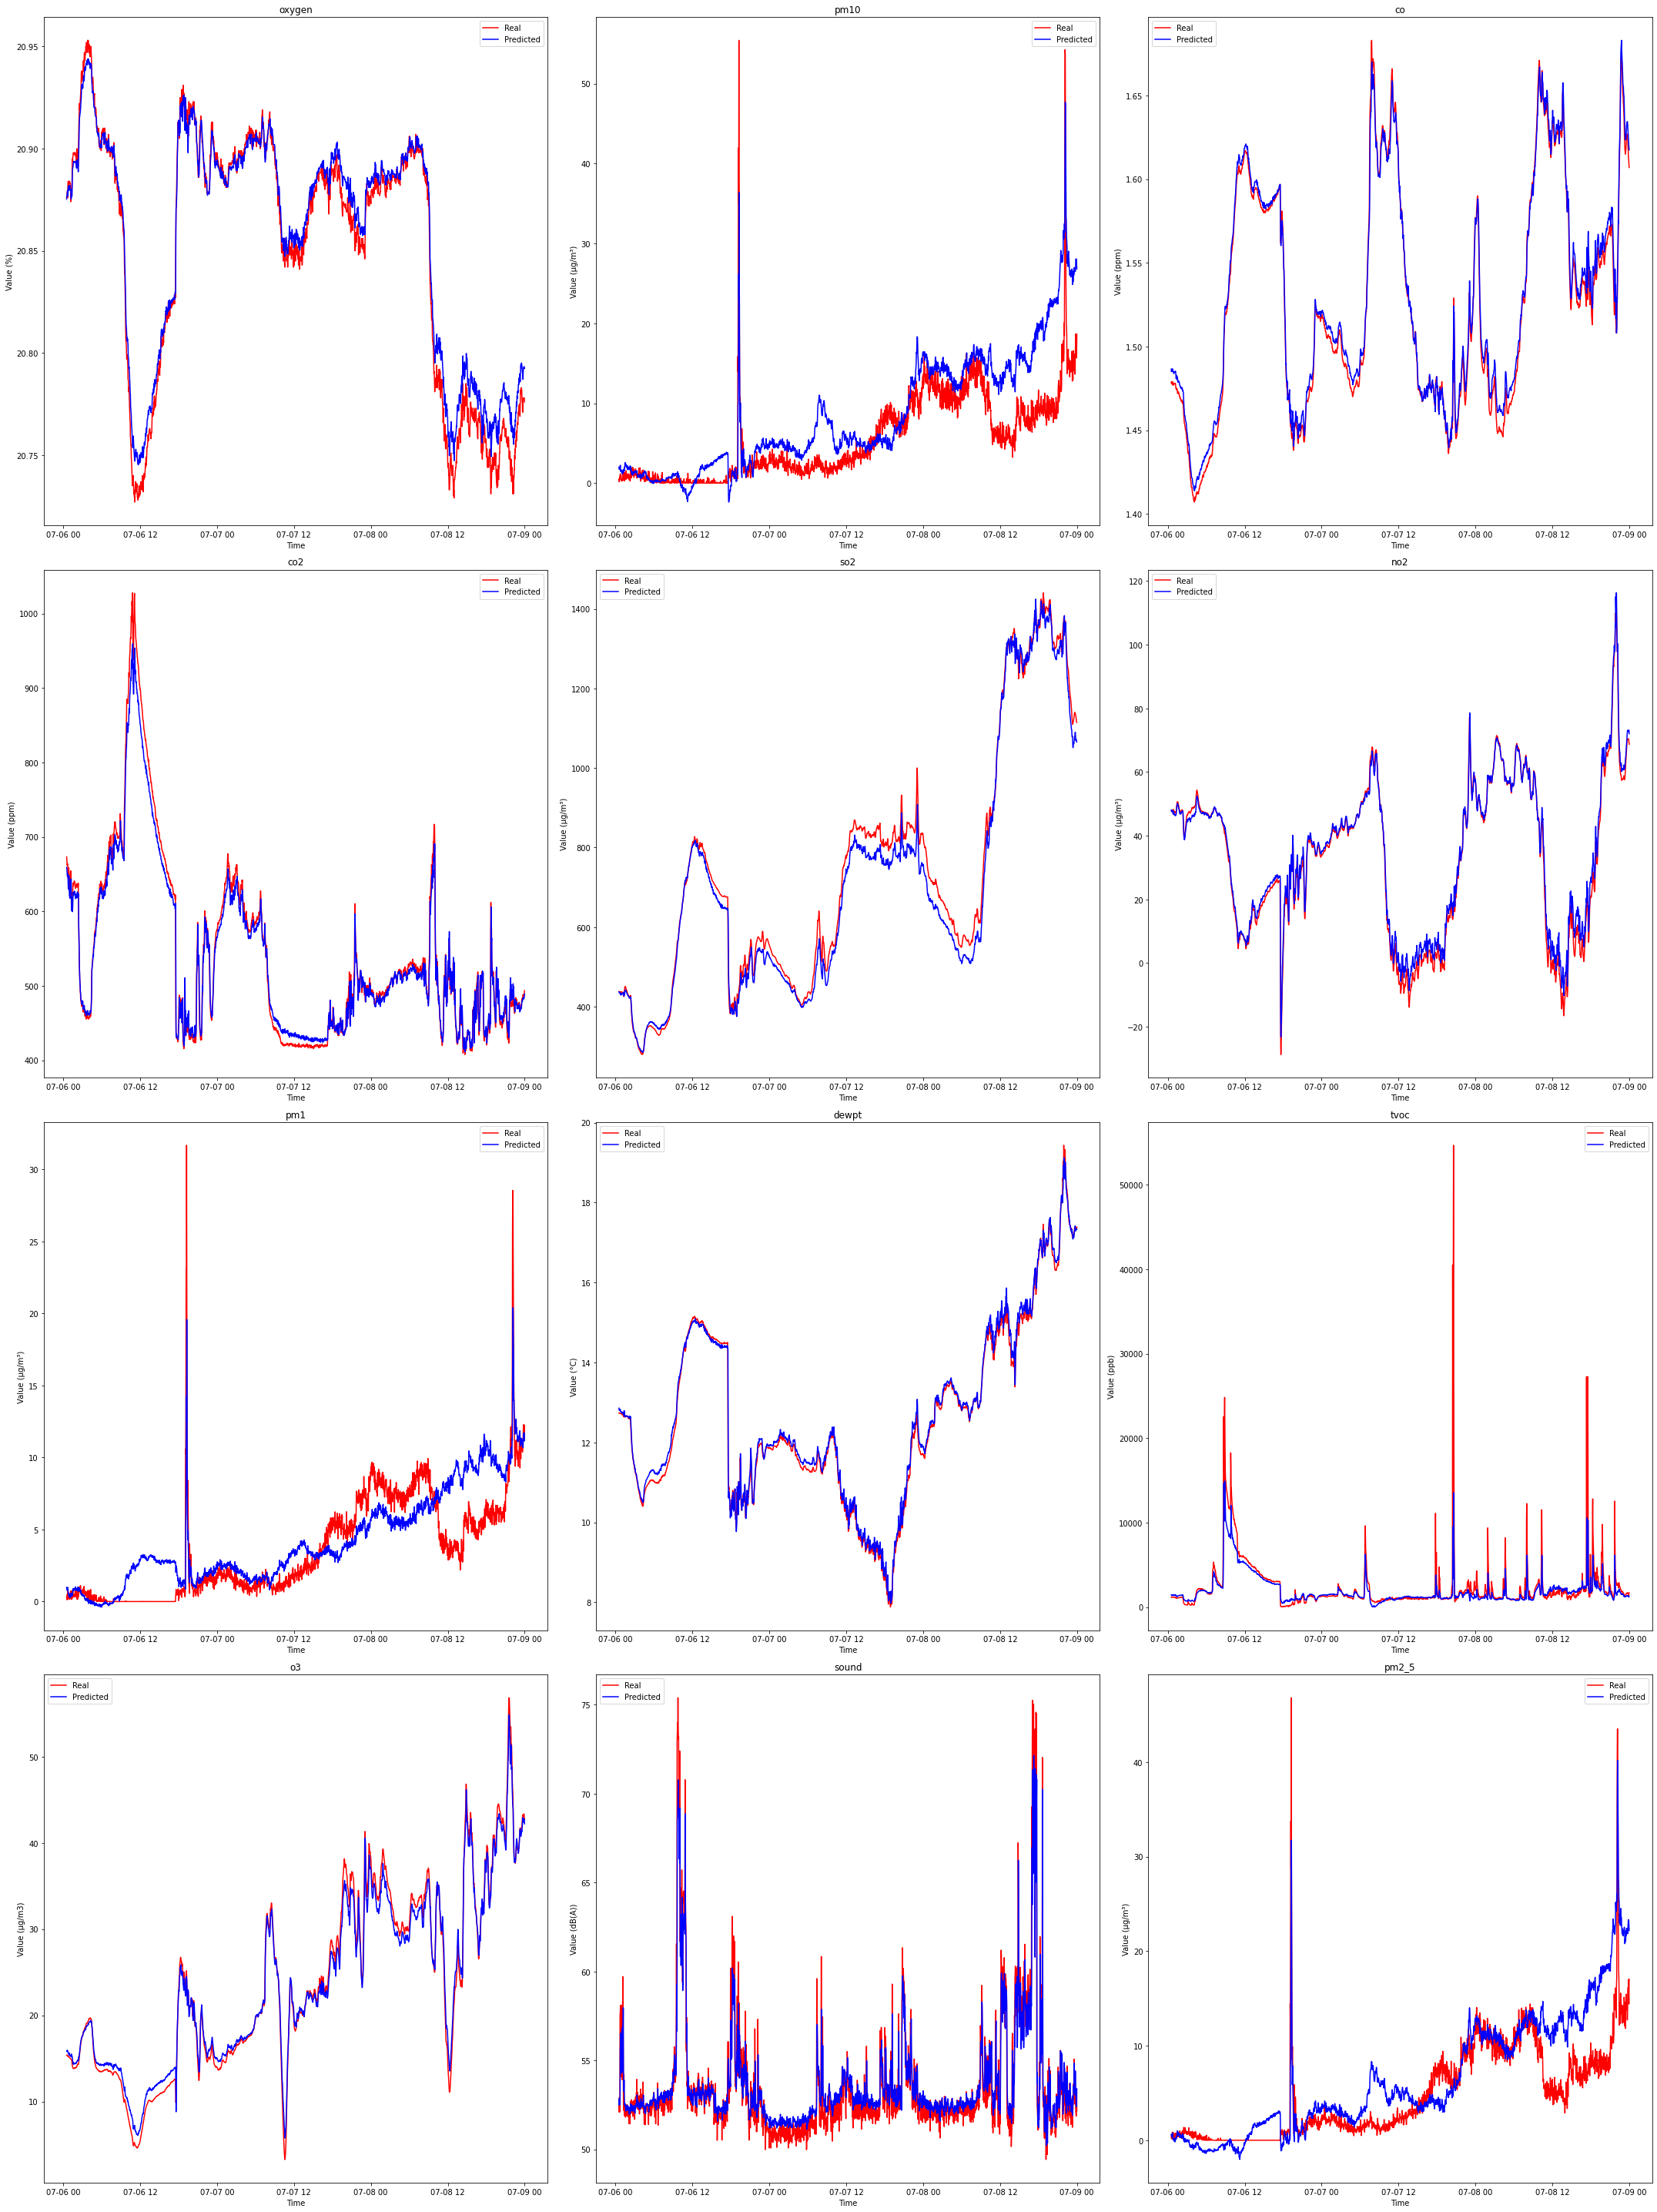

In [39]:
dates = dates[-test_y.shape[0]:]
fig, axs = plt.subplots(4, 3, figsize=(30, 40))
feature_indices = {
    'oxygen': 0, 'pm10': 1, 'co': 2, 'co2': 3, 'so2': 4,
    'no2': 5, 'pm1': 6, 'dewpt': 7, 'tvoc': 8, 'o3' : 9, 'sound': 10, 'pm2_5': 11
}
feature_units = {
    'oxygen': '%', 'pm10': 'µg/m³', 'co': 'ppm', 'co2': 'ppm',
    'so2': 'µg/m³', 'no2': 'µg/m³', 'pm1': 'µg/m³',
    'dewpt': '°C', 'tvoc': 'ppb', 'o3': 'µg/m3', 'sound': 'dB(A)', 'pm2_5': 'µg/m³'
}

for i, (feature, index) in enumerate(feature_indices.items()):
    row = i // 3
    col = i % 3

    axs[row, col].plot(dates,inv_y[:, index], color='red', label='Real')
    axs[row, col].plot(dates,inv_yhat[:, index], color='blue', label='Predicted')
    axs[row, col].set_title(feature)
    axs[row, col].set_xlabel('Time')
    axs[row, col].set_ylabel(f'Value ({feature_units[feature]})')
    axs[row, col].legend()

plt.tight_layout()
plt.show()


L'ensemble de tests commence par des données de comptage à la ligne 9393

In [40]:
print(inv_y.shape, inv_yhat.shape)

(2133, 12) (2133, 15)


In [41]:
selected_columns2 = [i for i in range(inv_y.shape[1]) if i not in [12, 13, 14]]
inv_yhat = inv_yhat[:, selected_columns2]
inv_y = inv_y[:, selected_columns2]

In [42]:
feature_names = ['oxygen', 'pm10', 'co', 'co2', 'so2', 'no2', 'pm1', 'dewpt', 'tvoc', 'o3', 'sound', 'pm2_5']

for i, feature in enumerate(feature_names):
    rmse = sqrt(mean_squared_error(inv_y[:, i], inv_yhat[:, i]))
    # mape = np.mean(np.abs((inv_y[:, i] - inv_yhat[:, i])/inv_y[:, i]))*100
    print(f'Test RMSE for {feature}: {rmse:.3f}')
    # print(f'Rest MAPE for {feature}: {mape:.3f}%')

Test RMSE for oxygen: 0.010
Test RMSE for pm10: 5.041
Test RMSE for co: 0.006
Test RMSE for co2: 16.719
Test RMSE for so2: 35.558
Test RMSE for no2: 2.794
Test RMSE for pm1: 2.323
Test RMSE for dewpt: 0.172
Test RMSE for tvoc: 2079.817
Test RMSE for o3: 1.160
Test RMSE for sound: 1.449
Test RMSE for pm2_5: 3.897


In [43]:
iaqi_condition_withouto3 = lambda x: (x[:, 6] <= 10) & (x[:, 11] <= 25) & (x[:, 1] <= 50) & (x[:, 3] < 800) & (x[:, 8] < 300)
iaqi_condition = lambda x: (x[:, 6] <= 10) & (x[:, 10] <= 25) & (x[:, 1] <= 50) & (x[:, 3] < 800) & (x[:, 8] < 300) & (x[:, 9] < 18)
inv_y_iaq = iaqi_condition_withouto3(inv_y).astype(int)
inv_yhat_iaq = iaqi_condition_withouto3(inv_yhat).astype(int)
inv_y_iaq2 = iaqi_condition(inv_y).astype(int)
inv_yhat_iaq2 = iaqi_condition(inv_yhat).astype(int)

inv_y = np.hstack((inv_y, inv_y_iaq.reshape(-1, 1)))
inv_yhat = np.hstack((inv_yhat, inv_yhat_iaq.reshape(-1, 1)))
inv_y2 = np.hstack((inv_y, inv_y_iaq2.reshape(-1, 1)))
inv_yhat2 = np.hstack((inv_yhat, inv_yhat_iaq2.reshape(-1, 1)))

In [44]:
# print("inv_y:\n", inv_y)
# print("inv_yhat:\n", inv_yhat)

In [45]:
accuracy_normalized = accuracy_score(inv_y[:,12], inv_yhat[:,12], normalize=True)
print("Accuracy: " + str(accuracy_normalized))

Accuracy: 0.9479606188466948


In [ ]:
accuracy_normalized = accuracy_score(inv_y2[:,12], inv_yhat2[:,12], normalize=True)
print("Accuracy: " + str(accuracy_normalized))

Accuracy: 0.9620253164556962


In [46]:
num_correct = accuracy_score(inv_y[:,12], inv_yhat[:,12], normalize=False)
print(num_correct) 

2022
